In [47]:
import sys
sys.path.append('../../')
from src.util.config import Config

**Setting**
create specific Single Item Auction setting with Return-on-Invest

In [48]:
# parameter mechanism
bidder = ['1']*2
o_space = {'1': [0.0, 1.0]}
a_space = {'1': [0.0, 1.0]}
param_prior = {
    'distribution':'uniform',
    'corr': 0.0,
    }
param_util = {
    'payment_rule': 'first_price', 
    'tie_breaking': 'random', 
    'utility_type': 'ROSB',
    'reserve_price': 0.05,
    'budget': 1.01,
    }
# parameter approximation game
n = 64
m = 64

config = Config()
config.create_config_game("single_item", bidder, o_space, a_space, param_prior, param_util, n, m)
game = config.create_game()
if not game.mechanism.own_gradient:
    print('not own gradient')
    game.get_utility()

not own gradient


**Learner**
Specify Learning Algorithm

In [40]:
# parameter learner
max_iter = int(1e1)
tol = 1e-5
stop_criterion = 'util_loss'
param_learner = {
    "mirror_map": "euclidean",
    "method": "standard",
    "steprule_bool": False,
    "eta": 1,
    "beta": 0.5,
}

config.create_config_learner("frank_wolfe", max_iter, tol, stop_criterion, param_learner)
learner = config.create_learner()

Run Learning Algorithm

In [33]:
import numpy as np

In [34]:
learner.gradient.compute(game, strategies, '1')
np.abs(learner.gradient.x['1'], game.mechanism.compute_gradient(game, strategies, '1')).max()

AttributeError: 'FrankWolfe' object has no attribute 'gradient'

In [46]:
game.mechanism.compute_probability_winning(game, strategies, '1')

array([0.00855826, 0.02494374, 0.04039784, 0.05588829, 0.07241911,
       0.0890249 , 0.10480665, 0.12012975, 0.13599088, 0.15274239,
       0.16838871, 0.18392824, 0.19959572, 0.21515721, 0.23086896,
       0.24634061, 0.26209312, 0.27882678, 0.29557517, 0.31045729,
       0.32464325, 0.33950397, 0.35561763, 0.37199088, 0.38739452,
       0.40261283, 0.41753954, 0.43309651, 0.44898171, 0.46327519,
       0.4777216 , 0.49406776, 0.51085291, 0.52756882, 0.54364626,
       0.55939389, 0.57560935, 0.59130731, 0.60643465, 0.62137304,
       0.63692769, 0.6527821 , 0.66869786, 0.68327027, 0.69818409,
       0.71384852, 0.72951032, 0.74586992, 0.76112978, 0.7761185 ,
       0.7920415 , 0.80762623, 0.82266808, 0.83761159, 0.85247942,
       0.86868017, 0.88451209, 0.89939233, 0.91520891, 0.93135584,
       0.94773044, 0.96292656, 0.97672797, 0.99184257])

In [45]:
strategies['1'].x.sum(axis=0)

array([0.01711652, 0.01565443, 0.01525377, 0.01572714, 0.01733451,
       0.01587707, 0.01568643, 0.01495977, 0.01676249, 0.01674052,
       0.01455212, 0.01652693, 0.01480804, 0.01631493, 0.01510857,
       0.01583473, 0.0156703 , 0.01779701, 0.01569977, 0.01406448,
       0.01430743, 0.01541401, 0.01681331, 0.01593319, 0.01487409,
       0.01556252, 0.01429091, 0.01682303, 0.01494736, 0.01363962,
       0.0152532 , 0.01743914, 0.01613115, 0.01730068, 0.01485421,
       0.01664103, 0.0157899 , 0.01560602, 0.01464867, 0.01522811,
       0.01588118, 0.01582764, 0.01600389, 0.01314093, 0.01668671,
       0.01464215, 0.01668144, 0.01603777, 0.01448194, 0.01549549,
       0.01635051, 0.01481894, 0.01526475, 0.01462229, 0.01511337,
       0.01728812, 0.01437573, 0.01538476, 0.01624841, 0.01604544,
       0.01670377, 0.01368847, 0.01391435, 0.01631486])

In [44]:
#create and initialize strategies
strategies = config.create_strategies(game, "random")

In [ ]:

# run learn algorithm
learner.run(game, strategies, disable_tqdm_bool=False, print_result_bool=True, save_history_bool=True)

Visualization of the learning process and the final result

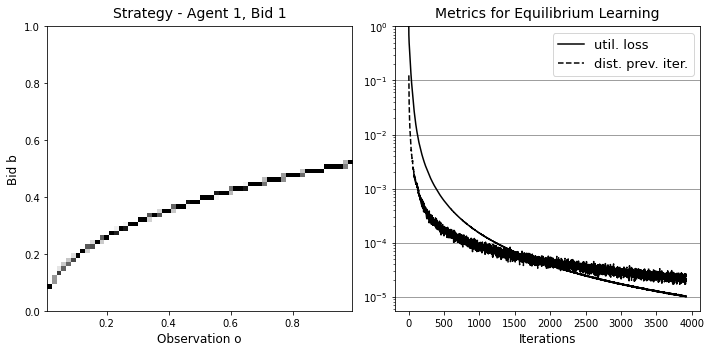

In [17]:
bne = game.mechanism.get_bne('1', strategies['1'].o_discr)
strategies['1'].plot(metrics=True, beta= bne)

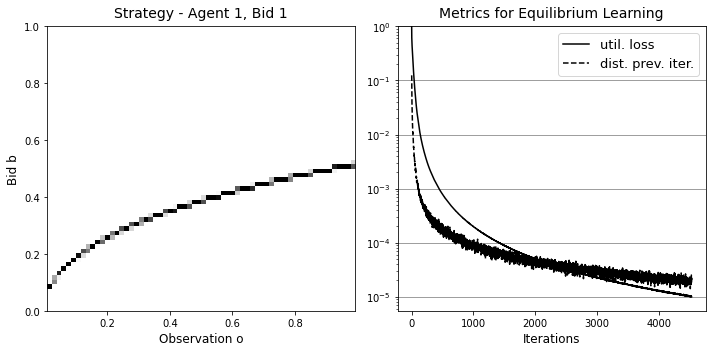

In [13]:
bne = game.mechanism.get_bne('1', strategies['1'].o_discr)
strategies['1'].plot(metrics=True, beta= bne)